In [1]:
# Optimal filter demo
import numpy as np
import matplotlib.pyplot as plt

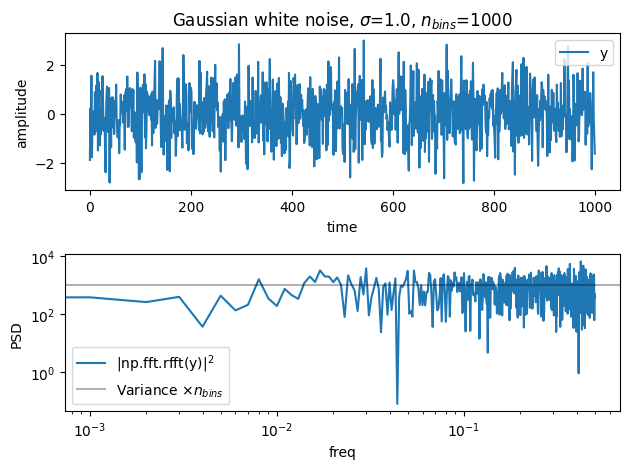

In [2]:
# let's look at white noise, and define a PSD function
noise_sigma = 1
dt = 1 # time step
nbins = 1000

t = np.arange(nbins)*dt
n = np.random.normal(0,noise_sigma,len(t))

def fourier(t,y,allreal=True):
    if allreal:
        yf = np.fft.rfft(y) # Fourier transform for real-valued y
        f  = np.fft.rfftfreq(len(y),dt) # frequencies >= 0
    else:
        yf = np.fft.fft(y)
        f  = np.fft.fftfreq(len(y),dt)
        yf = yf[f>=0] # frequencies >= 0
        f = f[f>=0]
    return f, yf

def periodogram(t,y,allreal=True):
    f,yf = fourier(t,y,allreal)
    return f, np.abs(yf)**2
    
f,p = periodogram(t,n)
true_psd = noise_sigma**2 * len(t) # includes how PSD is normalized

plt.subplot(211)
plt.title(r'Gaussian white noise, $\sigma$={0:.1f}, $n_{{bins}}$={1:d}'.format(noise_sigma,nbins))
plt.plot(t,n,label='y')
plt.xlabel('time'); plt.ylabel('amplitude'); plt.legend(loc=1)

plt.subplot(212)
plt.loglog(f,p,label='|np.fft.rfft(y)|$^2$')
plt.axhline(true_psd,color='k',ls='-',alpha=0.3,label=r'Variance $\times n_{bins}$')
plt.xlabel('freq'); plt.ylabel('PSD'); plt.legend(); plt.tight_layout()

The discrete Fourier transform done by `rfft` yields $\widetilde{y}_k = \sum_{m=0}^{n-1} y_m e^{-2\pi i m k/n}$

Just squaring the numpy fast Fourier transform (FFT) result gives amplitudes equal to the variance times the number of data points in the trace (the time-series data). The preferred CDMS "PSD" is given by $\sqrt{|FFT|^2 n_\text{bins}^{-1} \Delta f_{band}^{-1}}$, which is like the (square root) variability power (in the same physical units as the trace) per frequency interval

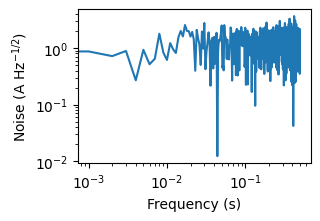

In [3]:
noise_psd = np.sqrt(p/(nbins*(0.5/dt))) # 0.5/dt = Nyquist freq
plt.figure(figsize=(3,2))
plt.loglog(f,noise_psd)
plt.xlabel('Frequency (s)')
plt.ylabel(r'Noise (A Hz$^{-1/2}$)'); # typical units

The optimal filter relies on the real and imaginary parts of the discrete Fourier transform to be Gaussian-distributed. We can verify this.

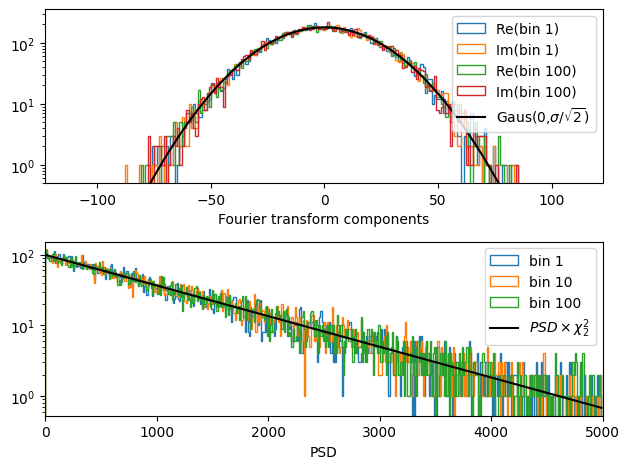

In [4]:
# how are the periodogram values distributed?
from scipy.stats import chi2 # <- spoiler
def gaus(x,mu,sigma): # <- spoiler x2
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))

nfs  = []
psds = []
N = 10000
for i in range(N):
    n = np.random.normal(0,noise_sigma,len(t))
    f,nf = fourier(t,n,True)
    p = np.abs(nf)**2
    nfs.append(nf)
    psds.append(p)
nfs = np.array(nfs)
psds = np.array(psds)

# the DFT components are Gaussian-distributed
plt.subplot(211)
fsigma = np.sqrt(true_psd/2) # generic result for DFT, e.g. Wang & Uhlenbeck 1945
binsize=1
bins = np.arange(-5*fsigma,5*fsigma,binsize)
for ibin in [1,100]:
    plt.hist(np.real(nfs[:,ibin]),bins=bins,histtype='step',label=f'Re(bin {ibin})')
    plt.hist(np.imag(nfs[:,ibin]),bins=bins,histtype='step',label=f'Im(bin {ibin})')

fgaussian = gaus(bins,0,fsigma)*N*binsize
plt.plot(bins,gaus(bins,0,fsigma)*N*binsize,'k-',label=r'Gaus(0,$\sigma/\sqrt{2}$)')
    
plt.xlabel(r'Fourier transform components')
plt.ylim(.5,2*N*binsize*gaus(0,0,fsigma))
plt.yscale('log')
plt.legend(loc=1)

# the binned PSD values are I.I.D. and follow a chi-squared dist. with dof=2 times noise_sigma^2 / 2
plt.subplot(212)
binsize = 10
bins = np.arange(0,5*true_psd,binsize)
for ibin in [1,10,100]:
    plt.hist(psds[:,ibin],bins=bins,histtype='step',label=f'bin {ibin}')

plt.plot(bins,N*(binsize*2/true_psd)*chi2.pdf(bins/(true_psd/2),2),'k-',label=r'$PSD\times \chi^2_2$')
# cross-check, draw from chi2 distribution itself
#chi2s = true_psd*chi2.rvs(2, size=N)/2
#plt.hist(chi2s,bins=bins,histtype='step',label=r'$\frac{1}{2}\sigma^2\times \chi^2_2$',color='k')

plt.xlabel(r'PSD')
plt.xlim(0,5*true_psd)
plt.yscale('log')
plt.legend(loc=1)
plt.tight_layout()

We now introduce a pulse, then implement a simple "optimal filter" (Zadeh & Ragazzini 1952), that also allows for a time-domain delay

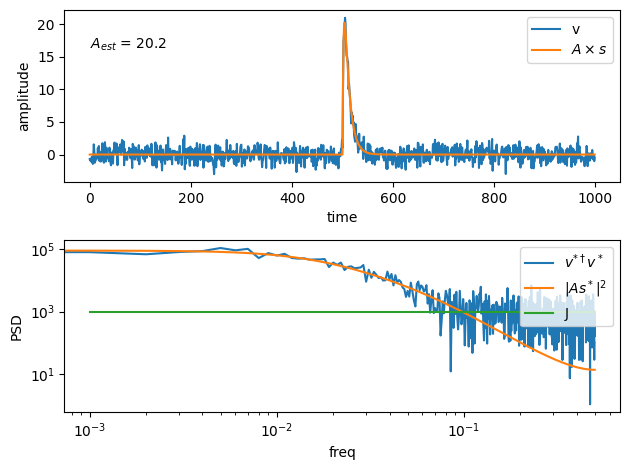

In [5]:
# build optimal filter, and run on a single noisy pulse

# define Pulse
def Pulse2(t, tau1, tau2, t0=0):
    pulse = np.zeros(len(t))
    dt = t - t0
    m = (dt>0)
    pulse[m] = (np.exp(-dt[m]/tau1)-np.exp(-dt[m]/tau2))
    norm = 1/((tau2/tau1)**(tau2/(tau1-tau2)) - (tau2/tau1)**(tau1/(tau1-tau2)))
    pulse *= norm
    return pulse

# define these values, again
nbins = 1000
dt = 1
t = np.arange(nbins)*dt
noise_sigma = 1
pulse_amp = 20
t1,t2 = 2,10

# Noah notation
t = np.arange(nbins) * dt
s = Pulse2(t,t1,t2,0) # peaks at 1
f,sf = fourier(t,s)
n = np.random.normal(0,noise_sigma,len(t))
J = np.zeros(len(sf)) + noise_sigma**2  * len(t)
J[0] = np.inf # ignore DC component
phi = np.conjugate(sf)/J # optimal filter
norm = np.real(np.sum(phi*sf)) # force imaginaries to 0 (should be 0 anyway)

v = pulse_amp*Pulse2(t,t1,t2,nbins*dt/2) + n
vf = fourier(t,v)[1] # ignore the f this function returns

# OF-based amplitude calculation
# use inverse FFT trick; avoids looping over t0 and computing:
#   phases = np.exp(1j*2*np.pi*f*t0)
#   A = np.sum(phases*phi*vf) / norm
# note, however, that the delay is only optimized to within one time step
allAs = nbins/2*np.fft.irfft(phi*vf) / norm
chi2s = 2 * (np.sum(np.abs(vf)**2/J)-np.abs(allAs)**2*norm)
ind  = np.argmin(chi2s) # find the delay with the minimal chi2
t0   = ind*dt
A    = allAs[ind]

plt.subplot(211)
plt.plot(t,v,label='v')
plt.plot(t,A*Pulse2(t,t1,t2,t0=t0),label=r'$A\times s$')
plt.xlabel('time'); plt.ylabel('amplitude')
plt.legend(loc=1)
plt.text(0,0.8*A,r'$A_{{est}}$ = {0:.1f}'.format(A))

plt.subplot(212)
plt.loglog(f,np.abs(vf)**2,label=r'$v^{*\dagger}v^*$')
plt.loglog(f,np.abs(A*sf)**2,label=r'$|As^*|^2$')
plt.plot(f,J,label='J')
plt.xlabel('freq'); plt.ylabel('PSD')
plt.legend(loc=1)
plt.tight_layout()


Text(0, 0.5, 'amplitude')

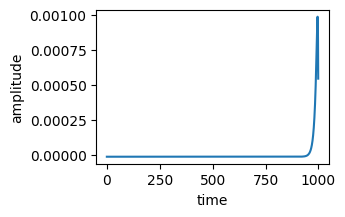

In [6]:
# what does the optimal filter look like in the time domain?
#   for white noise, a lot like the pulse!
plt.figure(figsize=(3,2))
plt.plot(t,np.fft.irfft(phi))
plt.xlabel('time'); plt.ylabel('amplitude')

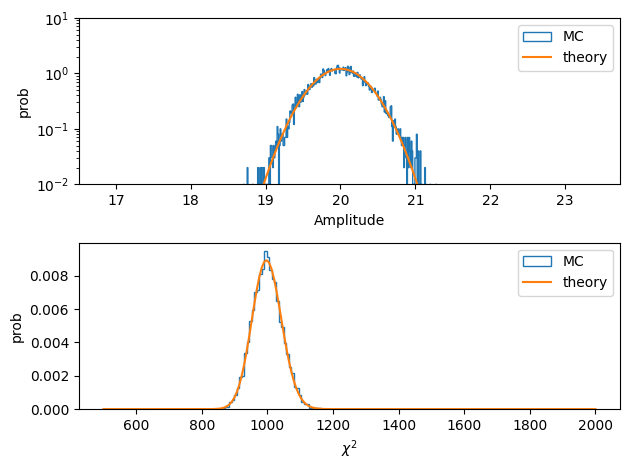

In [7]:
# check the chi2 and resolution calculations

# predicted resolution
varA = 0.5/np.sum(np.abs(sf)**2/J)
sigA = np.sqrt(varA)

# Monte Carlo
N = 10000
pulse_amp = 20
As = []
chi2s= []
t0  =  nbins*dt/2.0
s_t0 = Pulse2(t,t1,t2,t0)
for i in range(N):
    n = np.random.normal(0,noise_sigma,nbins)
    v = pulse_amp*s_t0 + n
    vf = np.fft.rfft(v)
    allAs = nbins/2*np.fft.irfft(phi*vf) / norm
    allchi2s = 2 * (np.sum(np.abs(vf)**2/J)-np.real(allAs)**2*norm)
    # shortcut, avoid chi2 = 2*np.sum(np.abs(vf - A*sf)**2/J)

    ind  = np.argmin(allchi2s)
    As.append(np.real(allAs[ind]))
    chi2s.append(allchi2s[ind])
    
plt.subplot(211)
Abins = np.arange(np.min(As)*0.9,np.max(As)*1.1,.01)
plt.hist(As,bins=Abins,density=True,histtype='step',label='MC')
plt.plot(Abins,gaus(Abins,pulse_amp,sigA),label='theory')
plt.xlabel(r'Amplitude')
plt.ylabel('prob')
plt.yscale('log')
plt.ylim(100/N,10)
plt.legend(loc=1)

plt.subplot(212)
dof = nbins -1
chi2bins = np.linspace(nbins/2,nbins*2,200)
plt.hist(chi2s,bins=chi2bins,density=True,histtype='step',label='MC')
plt.plot(chi2bins,chi2.pdf(chi2bins,dof),label='theory')
plt.xlabel(r'$\chi^2$')
plt.ylabel('prob')
plt.legend(loc=1)
plt.tight_layout()

The optimal filter behaves as expected! Now check various assumptions/deviations

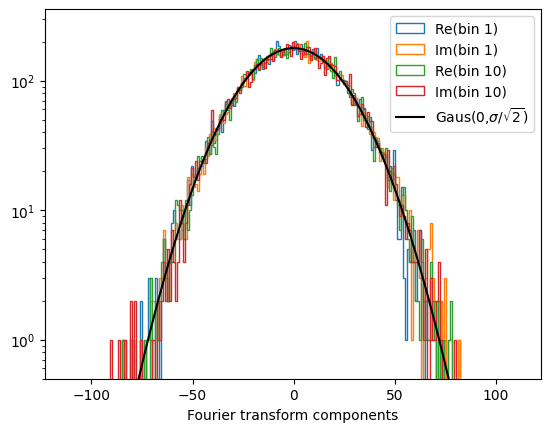

In [8]:
# verify that adding pulse in time domain + subtracting it in frequency domain does not affect residuals

# simulate a bunch of (s* - pulse FT), and check the distribution
y = pulse_amp*Pulse2(t,t1,t2,nbins*dt/2)
f,pulseft = fourier(t,y,True)

sfs = []
N = 10000
for i in range(N):
    n = np.random.normal(0,noise_sigma,len(t))
    s = y + n
    f,sf = fourier(t,s,True)
    sfs.append(sf-pulseft)
sfs = np.array(sfs)

binsize=1
bins = np.arange(-5*fsigma,5*fsigma,binsize)
for ibin in [1,10]:
    plt.hist(np.real(sfs[:,ibin]),bins=bins,histtype='step',label=f'Re(bin {ibin})')
    plt.hist(np.imag(sfs[:,ibin]),bins=bins,histtype='step',label=f'Im(bin {ibin})')

fgaussian = gaus(bins,0,fsigma)*N*binsize
plt.plot(bins,gaus(bins,0,fsigma)*N*binsize,'k-',label=r'Gaus(0,$\sigma/\sqrt{2}$)')
    
plt.xlabel(r'Fourier transform components')
plt.ylim(.5,2*N*binsize*gaus(0,0,fsigma))
plt.yscale('log')
plt.legend(loc=1)

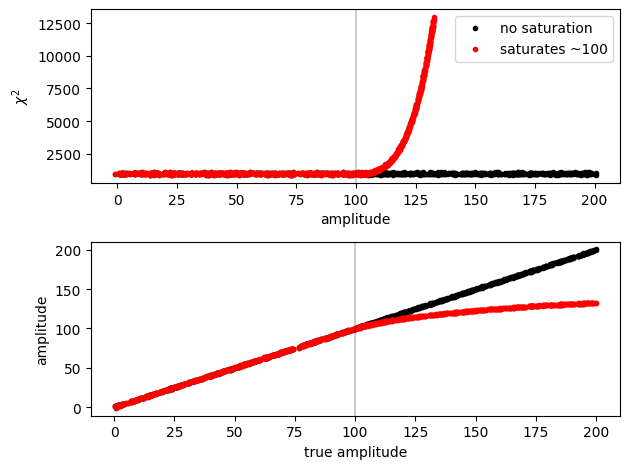

In [9]:
# Explore effects of saturation
# conclusion: saturation ruins amplitude, but bad chi2 alerts us of this
N = 1000
satval = 100
pulse_amps = np.random.uniform(0,2*satval,N)
As = []
chi2s= []
As_sat = []
chi2s_sat= []
t0  =  nbins*dt/2.0
s_t0 = Pulse2(t,t1,t2,t0)
for i in range(N):
    n = np.random.normal(0,noise_sigma,nbins)
    v = pulse_amps[i]*s_t0 + n
    vf = np.fft.rfft(v)
    allAs = nbins/2*np.fft.irfft(phi*vf) / norm
    allchi2s = 2 * (np.sum(np.abs(vf)**2/J)-np.real(allAs)**2*norm)
    ind  = np.argmin(allchi2s)
    As.append(np.real(allAs[ind]))
    chi2s.append(allchi2s[ind])
    # simulate saturation
    v_sat = v
    v_sat[v_sat>satval] = satval
    vf = np.fft.rfft(v_sat)
    allAs = nbins/2*np.fft.irfft(phi*vf) / norm
    allchi2s = 2 * (np.sum(np.abs(vf)**2/J)-np.real(allAs)**2*norm)
    ind  = np.argmin(allchi2s)
    As_sat.append(np.real(allAs[ind]))
    chi2s_sat.append(allchi2s[ind])
    
plt.subplot(211)
plt.plot(As,chi2s,'k.',label='no saturation')
plt.plot(As_sat,chi2s_sat,'r.',label=f'saturates ~{satval}')
plt.axvline(satval,color='k',alpha=0.2)
plt.legend()
plt.xlabel('amplitude')
plt.ylabel(r'$\chi^2$')

plt.subplot(212)
plt.plot(pulse_amps,As,'k.',label='no saturation')
plt.plot(pulse_amps,As_sat,'r.',label=f'saturates ~{satval}')
plt.axvline(satval,color='k',alpha=0.2)
plt.xlabel('true amplitude')
plt.ylabel('amplitude')
plt.tight_layout()

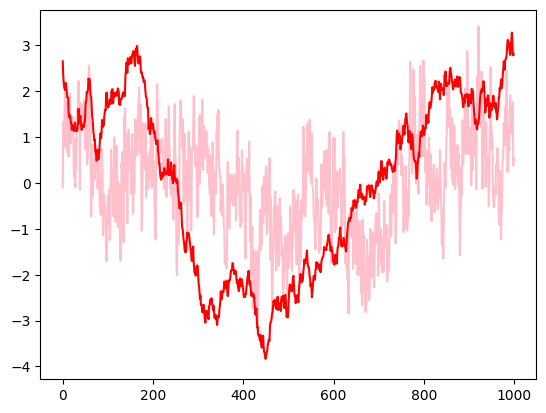

In [10]:
# Define PSD -> trace generator for different noise colors
def colornoise(t,f,sigma,index,PSD=False):
    dt = (t[1]-t[0])
    J = np.zeros(len(f))
    J[1:] = f[1:]**index # avoid dividing by 0
    J /= np.trapz(J[1:],f[1:])
    J *= sigma**2 * len(t) / (2*dt)
    if PSD:
        J[0] = np.inf
        return J
    norm = np.sqrt(J/2)
    rtJ = np.random.normal(0,1,len(f))*norm*1j
    rtJ += np.random.normal(0,1,len(f))*norm
    rtJ[0] = 0
    return np.fft.irfft(rtJ)

plt.plot(t,colornoise(t,f,1.0,0),color='white') # haha
plt.plot(t,colornoise(t,f,1.0,-1),color='pink')
plt.plot(t,colornoise(t,f,1.0,-2),color='red')

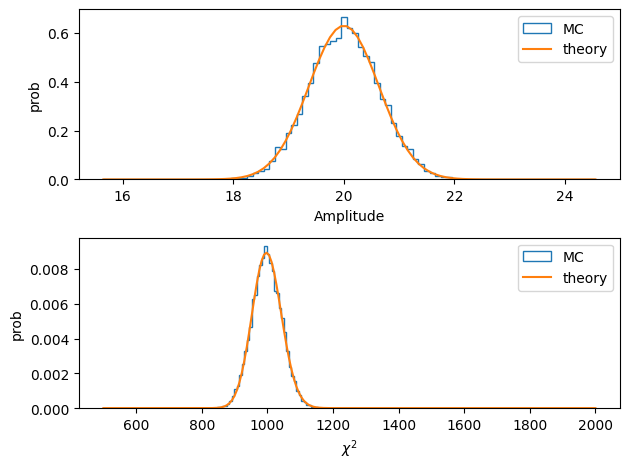

In [11]:
# From white to pink noise ~ f^-1
# conclusion: still works!

N = 10000
pulse_amp = 20
index = -1

As = []
chi2s= []
s = Pulse2(t,t1,t2,0) # peaks at 1
sf = np.fft.rfft(s)
t0  =  nbins*dt/2.0
s_t0 = Pulse2(t,t1,t2,t0)
J = colornoise(t,f,noise_sigma,index,PSD=True)
phi = np.conjugate(sf)/J # optimal filter
norm = np.real(np.sum(phi*sf))
for i in range(N):
    n = colornoise(t,f,noise_sigma,index)
    v = pulse_amp*s_t0 + n
    vf = np.fft.rfft(v)
    allAs = nbins/2*np.fft.irfft(phi*vf) / norm
    allchi2s = 2 * (np.sum(np.abs(vf)**2/J)-np.real(allAs)**2*norm)
    # shortcut, avoid chi2 = 2*np.sum(np.abs(vf - A*sf)**2/J)

    ind  = np.argmin(allchi2s)
    As.append(np.real(allAs[ind]))
    chi2s.append(allchi2s[ind])
    
# predicted resolution
varA = 0.5/np.sum(np.abs(sf)**2/J)
sigA = np.sqrt(varA)

plt.subplot(211)
Abins = np.arange(np.min(As)*0.9,np.max(As)*1.1,.1)
plt.hist(As,bins=Abins,density=True,histtype='step',label='MC')
plt.plot(Abins,gaus(Abins,pulse_amp,sigA),label='theory')
plt.xlabel(r'Amplitude')
plt.ylabel('prob')
plt.legend(loc=1)

plt.subplot(212)
dof = nbins -1
chi2bins = np.linspace(nbins/2,nbins*2,200)
plt.hist(chi2s,bins=chi2bins,density=True,histtype='step',label='MC')
plt.plot(chi2bins,chi2.pdf(chi2bins,dof),label='theory')
plt.xlabel(r'$\chi^2$')
plt.ylabel('prob')
plt.legend(loc=1)
plt.tight_layout()
